# Assignment 1: Propagation and pass prediction 
This Jupyter Notebook is used in the Satellite Orbits Determination practical. This notebook consists of 5 parts:

    - Propagation from a TLE 
    - Pass prediction over Delft ground station
    - Load real observational data
    - Compare simulated and recorded data for single pass
    - Reporting

Follow the text and code to perform the practical.

### UNITS and conventions
All parameters are represented in SI units or otherwise stated.

### Code usage
In this course you are using actual tracking data from the DopTrack laboratory (https://doptrack.tudelft.nl) and use the Delft-based orbit determination software Tudat (https://docs.tudat.space/en/stable/#) to perform orbit analysis.

In [1]:
# Load standard modules
import cartopy.crs as ccrs
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression # linear regression module

from propagation_functions.environment import *
from propagation_functions.propagation import *
from utility_functions.time import *
from utility_functions.tle import *
from estimation_functions.observations_data import *
from estimation_functions.estimation import *

# Load tudatpy modules
from tudatpy.kernel import constants
from tudatpy.kernel.interface import spice
from tudatpy.kernel.numerical_simulation import propagation_setup
from tudatpy.kernel.astro import element_conversion

Now that all software is imported, it is time to load in an predetermined initial state of the satellite. Ussually, during launch of a new satellites, lauchers companies provide a pre-launch TLE. When the satellite is already in orbit (daily) updated TLE's are available. The TLE data is a Two Line Element writtin in ascii format stating the state of the satellite at a certain time. With propagation software an orbit can be propagated from that initial state.

Here, we extract the initial state from the TLE and not use the proprietary propagator SGP4, but use tudat software to propagate the orbit of the satellite. This allows us to fully use all the information in tudat on gravity fields, 3rd bodies, atmospheres, etc.

Within the DopTrack facility we use a metafile system that is ordered as follows:

>`nameSat_NORADID_yearmonthdayhourmin.yml`

In this metafile are the TLE listed that are most up to date for certain passes. You can open the .yml files with a text editor to inspect the structure of the meta file and the contents of it.

**IN THIS BLOCK**: you can set the `nb_days_to_propagate` parameter to set the time you want to propagate in the future from the time listed in the TLE.

In [2]:
# Define import folders
metadata_folder = 'metadata/'
data_folder = 'data/'

# Metadata input file
metadata_file = metadata_folder + 'Delfi-C3_32789_202004020904.yml'

# Retrieve initial state from TLE and associated time
initial_epoch, initial_state_teme, b_star_coef = get_tle_initial_conditions(metadata_file)

# Define start of the day (initial time of the propagation)
start_recording_day = get_start_next_day(initial_epoch)

# Define end of the day (final time of the propagation)
nb_days_to_propagate = 1.0
final_epoch = start_recording_day + nb_days_to_propagate * 86400.0 

print('----------------------------------------')
print('Initial epoch: ', initial_epoch)
print('Initial state TEME: ')
print(initial_state_teme)
print('Final epoch', final_epoch)

----------------------------------------
Initial epoch:  638983817.0000017
Initial state TEME: 
[-5.12028710e+06  4.67186002e+06 -1.02444750e+03  6.61803701e+02
  7.22033885e+02  7.51805584e+03]
Final epoch 639144000.0


# --------------------------------------
# 1: Propagate dynamics of a satellite
# --------------------------------------

With the initial state and the time of propagation set, we need to define the dynamical model we will use in the propagation. Here, the tudat software will help us a lot. Many physical forcings have been coded in the software such as gravitational models, ephemerides of planets, atmosphere models, solar radiation pressure, etc. Furthermore, numerous numerical tools are implemented in tudat, such as coordinate transformations, reference frame transformations, and different propagators. 

More on all these utilities can be found in the Numerical Astrodynamics course by Dominic Dirkx or dive in the documentation of tudat at https://docs.tudat.space/en/stable/# 

**IN THIS BLOCK**: You can set the dynamical model and propagate the orbit of the chosen satellite.

===============  STARTING SINGLE-ARC PROPAGATION  ===============

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Kepler elements of Delfi w.r.t. Earth
[6], Spherical position angle latitude angle of Delfi w.r.t. Earth
[7], Spherical position angle longitude angle of Delfi w.r.t. Earth
[8], Single acceleration norm of type central gravity , acting on Delfi, exerted by Sun
[9], Single acceleration norm of type cannonball radiation pressure , acting on Delfi, exerted by Sun
[10], Single acceleration norm of type central gravity , acting on Delfi, exerted by Moon
[11], Single acceleration norm of type spherical harmonic gravity , acting on Delfi, exerted by Earth
[12], Single acceleration norm of type aerodynamic , acting on Delfi, exerted by Earth
[13], Single acceleration norm of type central gravity , acting on Delfi, exerted 

Warning when processing deprecated propagator settitngs, integrator settings defined independently, and in propagator settings


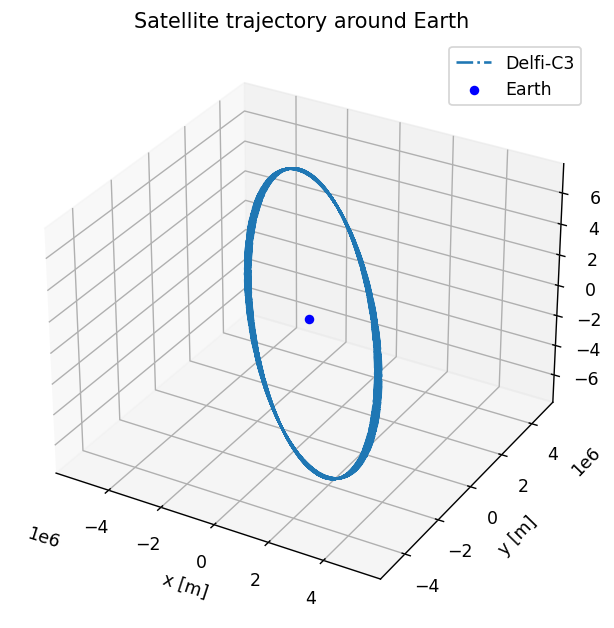

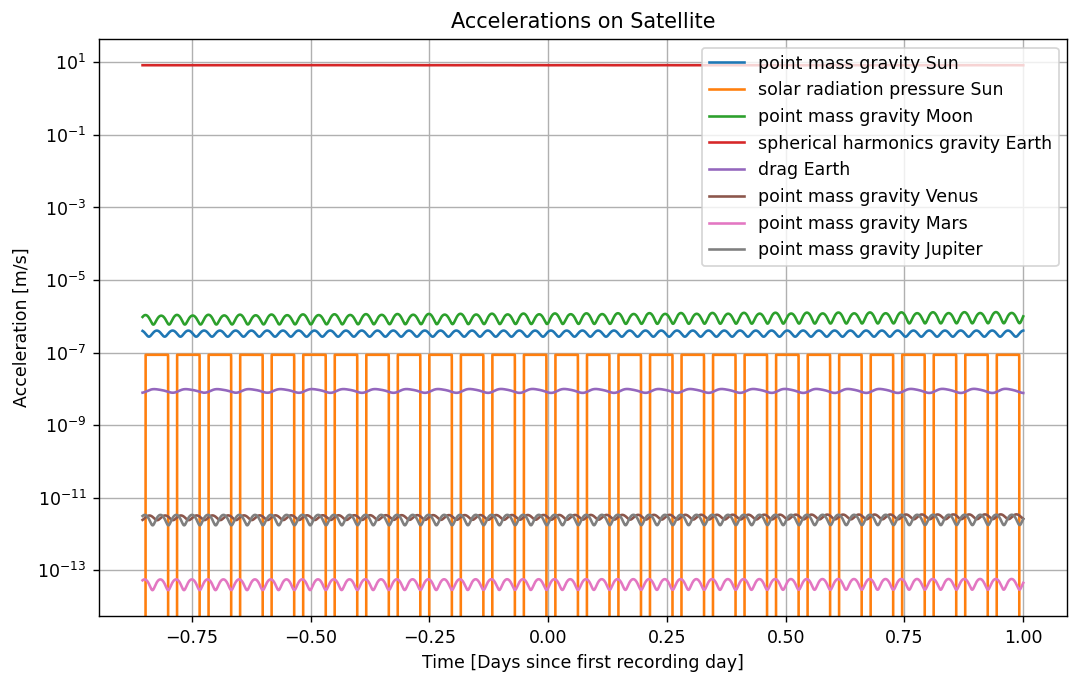

In [3]:
# Define the propagation environment. This function creates a body "Delfi" with the following characteristics.
# The Earth, Sun and Moon are also created, with default settings (gravity field, ephemeris, rotation, etc.)
mass_delfi = 2.2
ref_area_delfi = 0.035
drag_coefficient_delfi = get_drag_coefficient(mass_delfi, ref_area_delfi, b_star_coef, from_tle=True)
srp_coefficient_delfi = 1.2
bodies = define_environment(mass_delfi, ref_area_delfi, drag_coefficient_delfi, srp_coefficient_delfi)

# Set Delfi's initial state to the TLE prediction
initial_state = element_conversion.teme_state_to_j2000(initial_epoch, initial_state_teme)

# Define accelerations exerted on Delfi
# The following can be modified. Warning: point_mass_gravity and spherical_harmonic_gravity accelerations should not be defined simultaneously for a single body
acceleration_models = dict(
    Sun={
        'point_mass_gravity': True,
        'solar_radiation_pressure': True
    },
    Moon={
        'point_mass_gravity': True
    },
    Earth={
        'point_mass_gravity': False,
        'spherical_harmonic_gravity': True,
        'drag': True
    },
    Venus={
        'point_mass_gravity': True
    },
    Mars={
        'point_mass_gravity': True
    },
    Jupiter={
        'point_mass_gravity': True
    }
)
accelerations, accelerations_to_save, accelerations_ids = create_accelerations(acceleration_models, bodies, save_accelerations=True)

# Create propagator settings
propagator_settings = create_propagator_settings(initial_state, initial_epoch, final_epoch, accelerations)

# Propagate dynamics of the Delfi satellite from initial_epoch to final_epoch, starting from initial_state
# The propagation output is given in cartesian and keplerian states, and the latitude/longitude of the spacecraft are also saved.
cartesian_states, keplerian_states, latitudes, longitudes, saved_accelerations =\
    propagate_initial_state(initial_state, initial_epoch, final_epoch, bodies, accelerations, True, accelerations_to_save)

# Plot propagated orbit
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot(111, projection='3d')
ax.set_title(f'Satellite trajectory around Earth')
ax.plot(cartesian_states[:, 1], cartesian_states[:, 2], cartesian_states[:, 3], label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
ax.legend()
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
plt.show()

# Plot accelerations exerted on Delfi
fig = plt.figure(figsize=(10,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Accelerations on Satellite')
for i in range(np.shape(saved_accelerations)[1]-1):
    ax.plot((saved_accelerations[:, 0]-start_recording_day)/86400, saved_accelerations[:, i+1], label=accelerations_ids[i], linestyle='-')
ax.legend()
ax.set_xlabel('Time [Days since first recording day]')
ax.set_ylabel('Acceleration [m/s]')
plt.yscale('log')
plt.grid()
plt.show()

### Dynamical model: Kepler coordinates
3D orbits are nice to look at but do not give a lot of information about the orbit itself. Therefore, normally the orbit can be plotted in its Keplerian coordinates. Can you discuss what the orbit of the chosen satellite is doing? What happens if you change the dynamical model by setting the gravitational model of the Earth to a point mass? And what happens if you set Drag to `False`? Did you expect this?

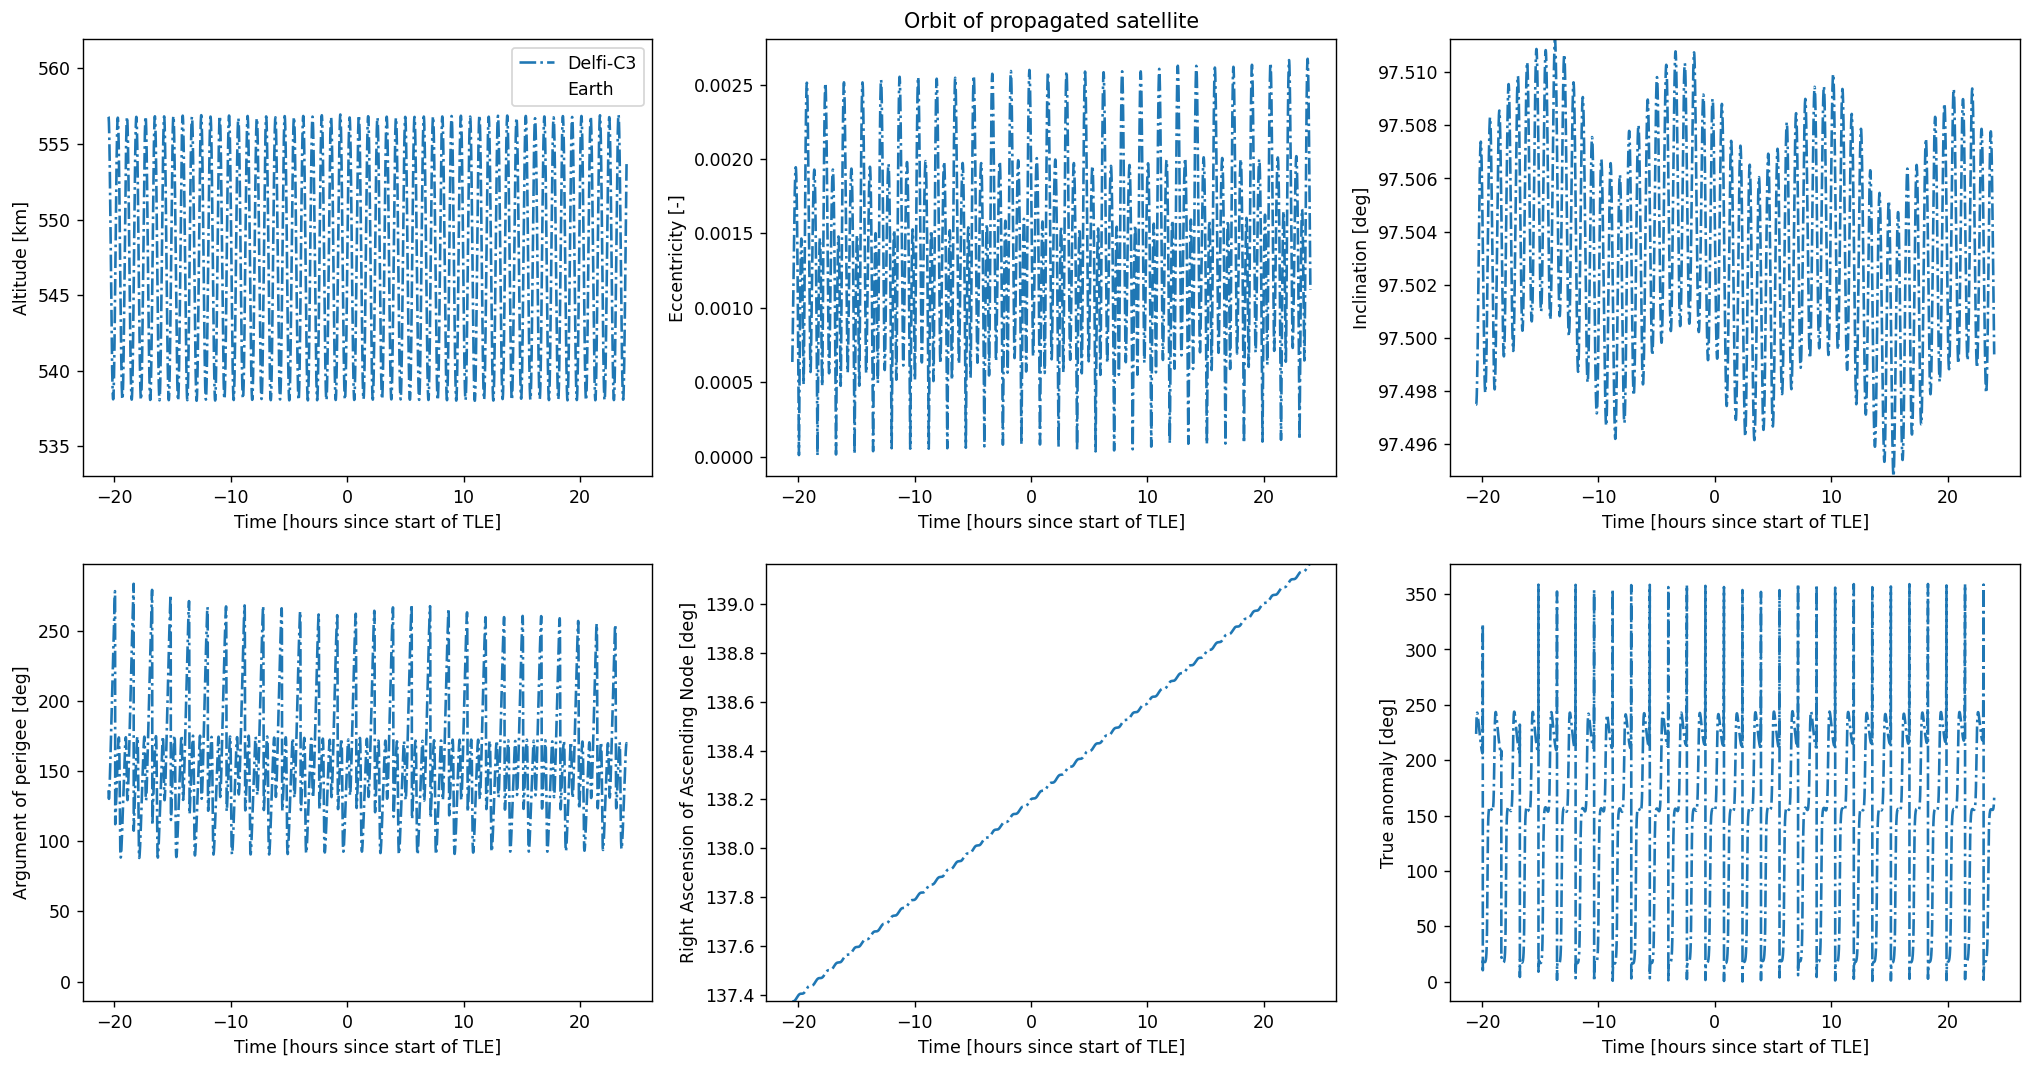

In [11]:
# Plot Keplerian coordinates and altitude of the propagated orbit
fig = plt.figure(figsize=(20,10), dpi=125)
ax = fig.add_subplot(231)
#ax.set_title(f'Altitude of delfi-C3')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, (keplerian_states[:,1]-6371360)/1000, label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
ax.legend()
ax.set_ylim(np.min((keplerian_states[:,1]-6371360)/1000)-5,np.max((keplerian_states[:,1]-6371360)/1000)+5)
#ax.set_ylim(556.5,557)
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('Altitude [km]')
#plt.show()

# eccentricity
ax = fig.add_subplot(232)
ax.set_title(f'Orbit of propagated satellite')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, keplerian_states[:,2], label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
#ax.legend()
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('Eccentricity [-]')
#plt.show()

# inclination
ax = fig.add_subplot(233)
#ax.set_title(f'Altitude of delfi-C3')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, keplerian_states[:,3]/np.pi*180, label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
#ax.legen
ax.set_ylim(np.min((keplerian_states[:,3])/np.pi*180),np.max((keplerian_states[:,3])/np.pi*180))
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('Inclination [deg]')
#plt.show()

ax = fig.add_subplot(234)
#ax.set_title(f'Altitude of delfi-C3')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, (keplerian_states[:,4])/np.pi*180, label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
#ax.legend()
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('Argument of perigee [deg]')
#plt.show()

# eccentricity
ax = fig.add_subplot(235)
#ax.set_title(f'Altitude of delfi-C3')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, keplerian_states[:,5]/np.pi*180, label='Delfi-C3', linestyle='-.')
ax.scatter(0.0,0.0, 0.0, label="Earth", marker='o', color='blue')
#ax.legend()
ax.set_ylim(np.min((keplerian_states[:,5])/np.pi*180),np.max((keplerian_states[:,5])/np.pi*180))
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('Right Ascension of Ascending Node [deg]')
#plt.show()

# inclination
ax = fig.add_subplot(236)
#ax.set_title(f'Altitude of delfi-C3')
ax.plot((keplerian_states[:, 0] - start_recording_day)/3600, keplerian_states[:,6]/np.pi*180, label='Delfi-C3', linestyle='-.')
ax.scatter(0.0, 0.0, 0.0, label="Earth", marker='o', color='blue')
#ax.legend()
ax.set_xlabel('Time [hours since start of TLE]')
ax.set_ylabel('True anomaly [deg]')
plt.show()


### Pass prediction: ground track and visibility

We need to link the orbit prediction to the ground station which is situated on the rotating Earth. We need to know when the satellite is flying over the ground station and into the field of view of the station. We need to determine when the satellite passes the horizon. For this we use the predicted orbit and plot the ground track with respect to the ground station location and its visibility circle.

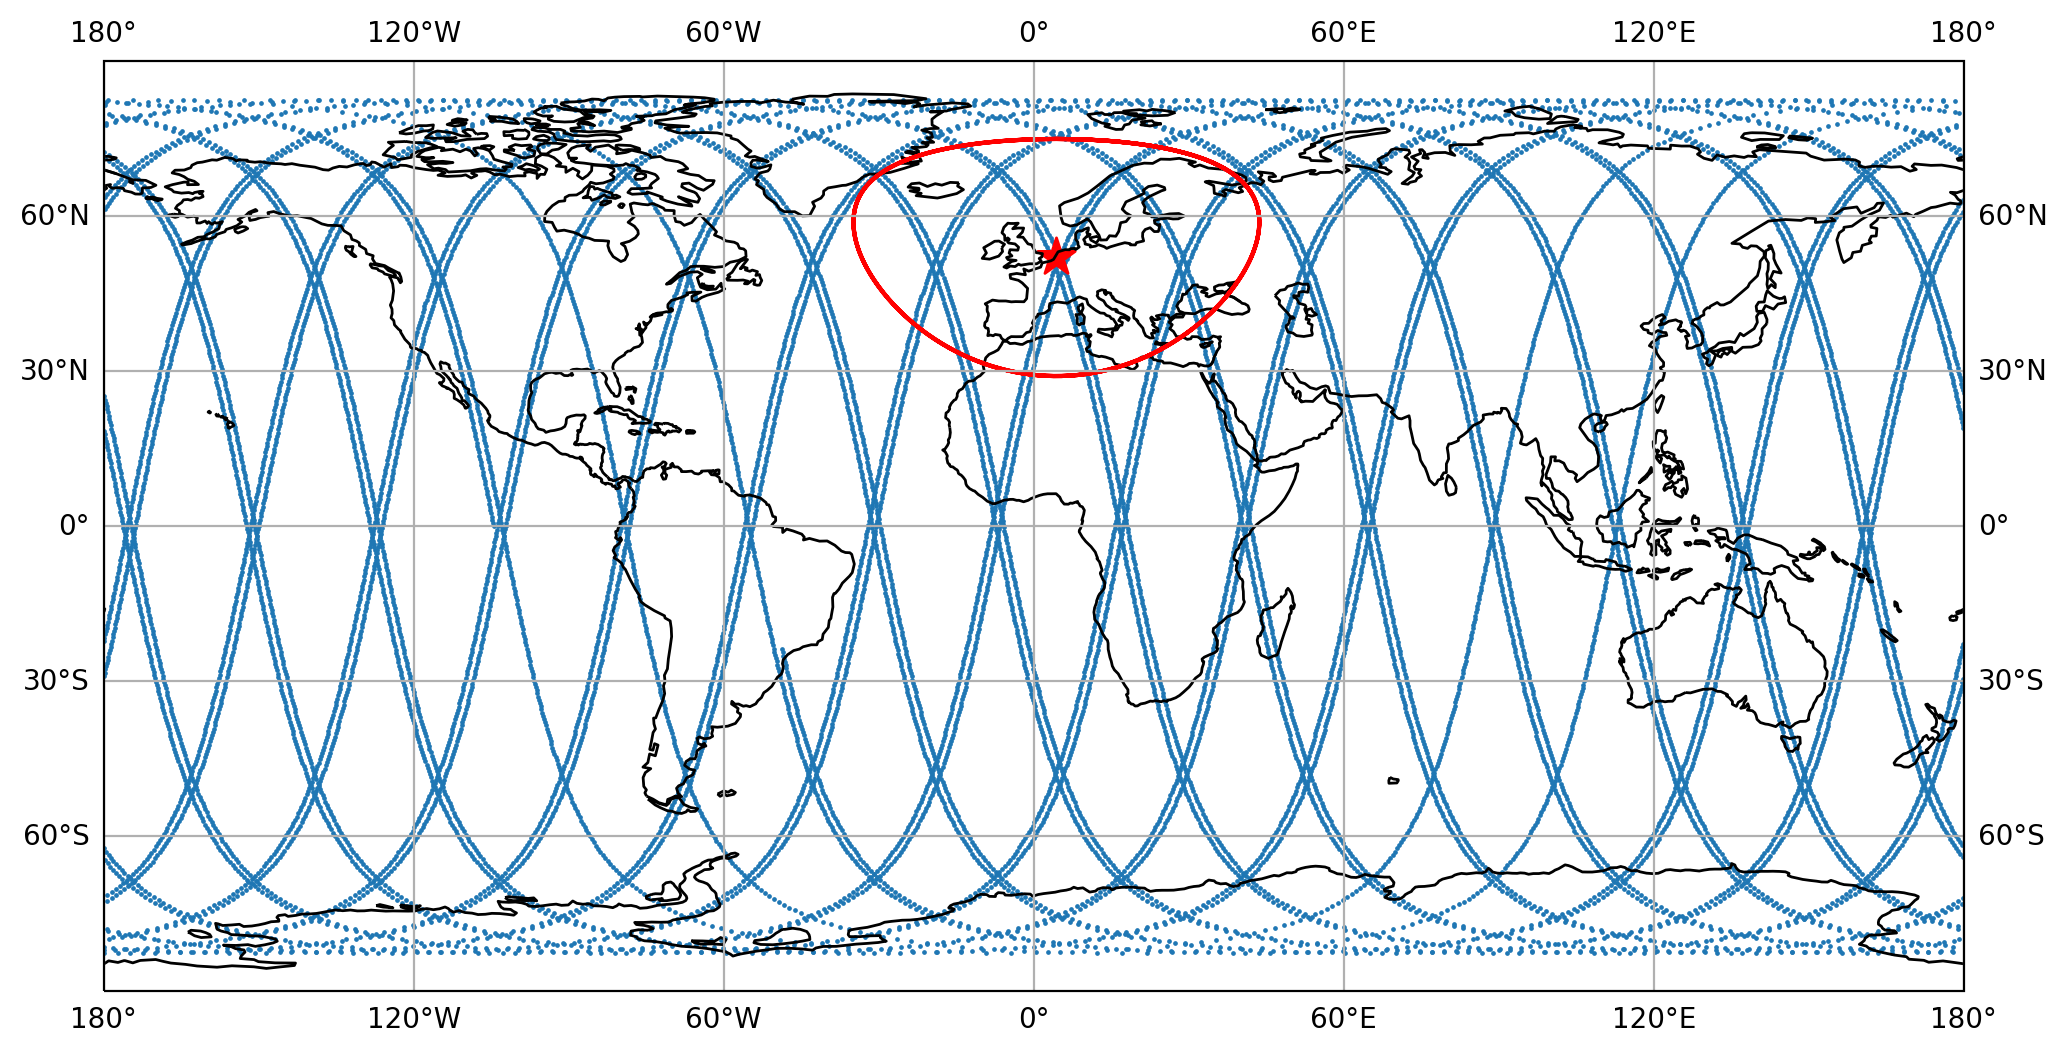

In [5]:
# plot the ground track and visibility circle of the DopTrack station

location_groundstation_lon = 4.3754
location_groundstation_lat = 51.9899

R = 6371360 
h =  547500;
Lambda = np.arccos((R)/(R+h))
Phi_E = np.linspace(0, 2*np.pi, num=1000)

# Create hemisphere function
mask_E = []
for i in range(len(Phi_E)):
    val = (-Phi_E[i]) % 2*np.pi
    if val >= 0 and val < np.pi: 
        mask_E.append(1.0)
    else:
        mask_E.append(-1.0)
     
    
# Calculate horizon coordinates on the map. 
colat_horizon = np.arccos(np.cos(Lambda)*np.cos((90-location_groundstation_lat)/180*np.pi)+np.sin(Lambda)*np.sin((90-location_groundstation_lat)/180*np.pi)*np.cos(Phi_E % 2*np.pi)) 
DL = ((mask_E * np.arccos((np.cos(Lambda)-np.cos(colat_horizon)*np.cos((90-location_groundstation_lat)/180*np.pi))/(np.sin((90-location_groundstation_lat)/180*np.pi)*np.sin(colat_horizon)))))
                        
LAT_horizon = (90-(colat_horizon/np.pi*180))
LON_horizon_abs = ((location_groundstation_lon/180*np.pi-DL)/np.pi*180) 
LON_horizon = np.where(LON_horizon_abs <= 180, LON_horizon_abs, LON_horizon_abs - 360)
             
# plot groundtrack with visibility area of ground station
plt.figure(figsize = (12, 8), dpi=200)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.scatter(longitudes/np.pi*180, latitudes/np.pi*180, label='Delfi-C3', marker='.',s=2)
ax.scatter(location_groundstation_lon,location_groundstation_lat, color='red', marker='*',s=200)
ax.plot(LON_horizon,LAT_horizon,color ='red')
ax.gridlines(draw_labels=True)
plt.show()

# --------------------------------------
# 2: Detect passes and simulate Doppler
# --------------------------------------

Now that you are able to propagate orbits from a TLE data source and plot the ground track on the surface of the Earth, it is time to determine when a satellite is passing over the ground station (in Delft). This you will need to plan access to the DopTrack laboratory.

In previous code you can set the time of propagation to any value by changing the `nb_days_to_propagate` parameter. From literature it is found that TLE data is accurate up to 10 days for this application, having the most accurate orbit predictions close to the TLE time. With the resulting predicted orbit you can determine within that time period when the satellite is in the line of sight of the ground station.

With both the station position and the satellite position, you can estimate the time of the satellite over the horizon. The best way to visualize a satellite coming in view of a ground station is to make a 2-dimensional sketch of the situation

![horizon sketch](fig/Satellite_horizon.png)
 
The sketch of satellite passing over the local horizon. Where $\phi$ is the angle between the station position vector and the satellite position vector.

The parameter $\phi$ is the angle between the position vector of the satellite and the position vector of the station. You can calculate the value of this angle for when the satellite is just above the horizon. When the angle $\phi$ is larger than the corresponding $\phi$ angle of your satellite, then it is in view. The cosine of the angle can be calculated by taking the dot product of the two vectors and divide it by their norm.

>$\frac{R}{R+h} = \cos⁡(\phi_{horizon}) > \frac{R_{station} \cdot r_{sat}}{|R_{station}||r_{sat}|} $

The following graph can then be produced to depict when the satellite is visible from the ground station
 
![visibility plot](fig/Visibility_plot.jpg)

Using the visibility information allows you to plot the predicted elevation and azimuth angles for the different passes over Delft. This information is used to assess the quality of the pass. High maximum elevation typically gives better observation data. And both angles can be used for pointing certain antenna's in the local sky.

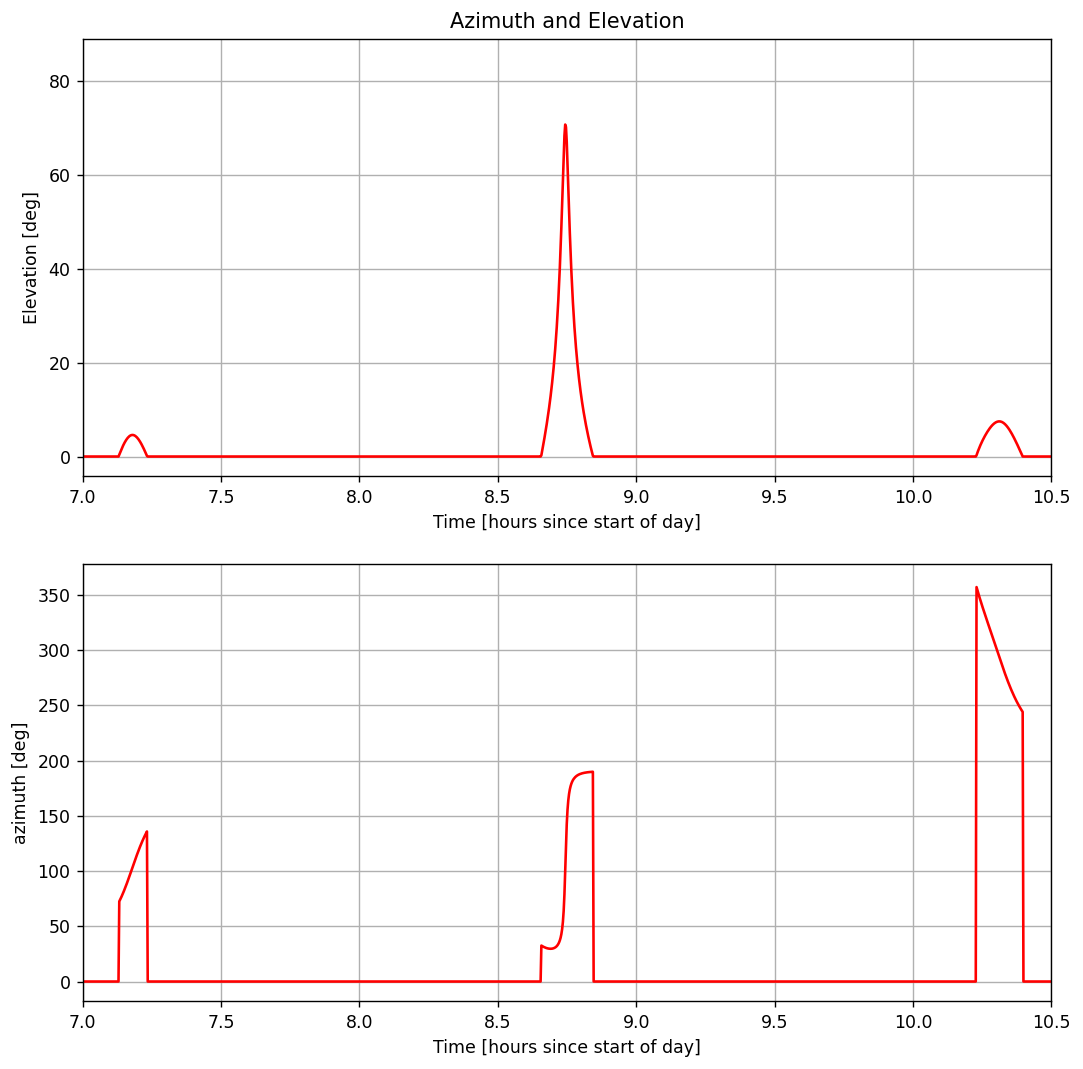

In [6]:
# plot elevation and azimuth of the passes (max and horizon)
sin_rho = R/(R+h)
DL_e = np.deg2rad(np.rad2deg(longitudes[:,1])-location_groundstation_lon)
Lambda_e = np.arccos(np.cos(latitudes[:,1])*np.cos(np.deg2rad(location_groundstation_lat))+np.sin(latitudes[:,1])*np.sin(np.deg2rad(location_groundstation_lat))*np.cos(DL_e))

eta = np.arctan2(sin_rho*np.sin(Lambda_e),1-sin_rho*np.cos(Lambda_e))
elevation_abs = np.rad2deg(np.arccos(np.sin(eta)/sin_rho))
elevation_lambda_check = np.where(Lambda_e <= np.arccos(R/(R+h)), elevation_abs, 0)
elevation = np.where(np.abs(DL_e)<= 0.5*np.pi, elevation_lambda_check, 0)

# Plot elevation
fig = plt.figure(figsize=(10,10), dpi=125)
ax = fig.add_subplot(211)
ax.set_title(f'Azimuth and Elevation')
ax.plot((longitudes[:,0] - start_recording_day)/3600, elevation, color='red')
#ax.set_xlim((simulated_obs_times[1] - start_recording_day)/3600,(simulated_obs_times[-1] - start_recording_day)/3600)
ax.set_xlim(7.0, 10.5)
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('Elevation [deg]')
plt.grid()
#plt.show()

# Azimuth calculation

# Create hemisphere function
mask_DL = []
for i in range(len(DL_e)):
    val = (DL_e[i]) % 2*np.pi
    if val >= 0 and val < np.pi: 
        mask_DL.append(1.0)
    else:
        mask_DL.append(-1.0)
        
# azimuth

azimuth_abs = np.rad2deg(mask_DL*np.arccos((np.cos(np.deg2rad(location_groundstation_lat))-np.cos(latitudes[:,1])*np.cos(Lambda_e))/(np.sin(latitudes[:,1])*np.sin(Lambda_e))))
azimuth_lambda_check = np.where(Lambda_e <= np.arccos(R/(R+h)), azimuth_abs, 0)
azimuth = np.where(np.abs(DL_e)<= 0.5*np.pi, azimuth_lambda_check, 0)

ax = fig.add_subplot(212)
ax.plot((longitudes[:,0] - start_recording_day)/3600, azimuth % 360, color='red')
#ax.set_xlim((simulated_obs_times[1] - start_recording_day)/3600,(simulated_obs_times[-1] - start_recording_day)/3600)
ax.set_xlim(7.0, 10.5)
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('azimuth [deg]')
plt.grid()
plt.show()

The predicted orbit and visibility information is used to simulate range-rate observations at the times of the predicted pass of the satellite over Delft. With the Doppler equation, the received radio frequency can be calculated from the simulated range-rate. 

Parameter start index, Parameter definition
0, translational state of (Delfi).

===============  STARTING SINGLE-ARC PROPAGATION  ===============

PROCESSED STATE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Translational state of body Delfi w.r.t. Earth

DEPENDENT VARIABLE VECTOR CONTENTS: 
[Vector entries], content description
[0:5], Kepler elements of Delfi w.r.t. Earth
[6], Spherical position angle latitude angle of Delfi w.r.t. Earth
[7], Spherical position angle longitude angle of Delfi w.r.t. Earth




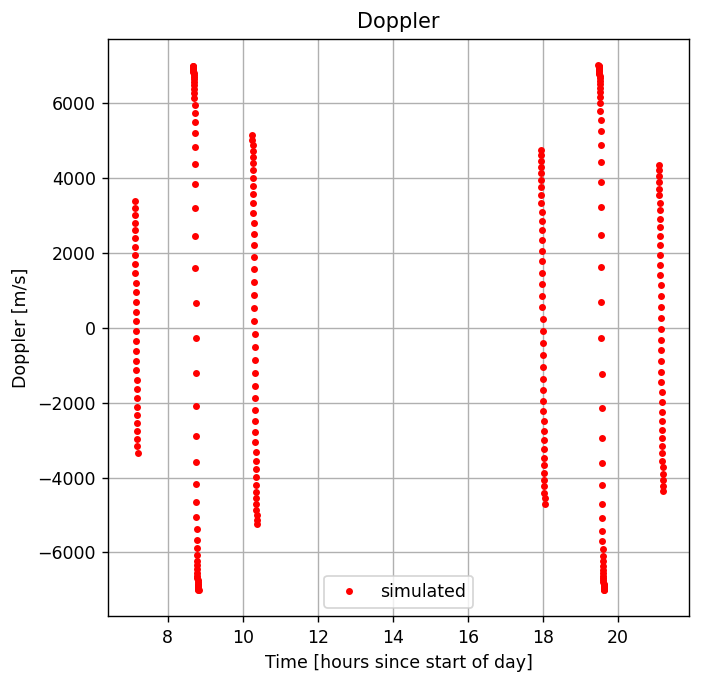

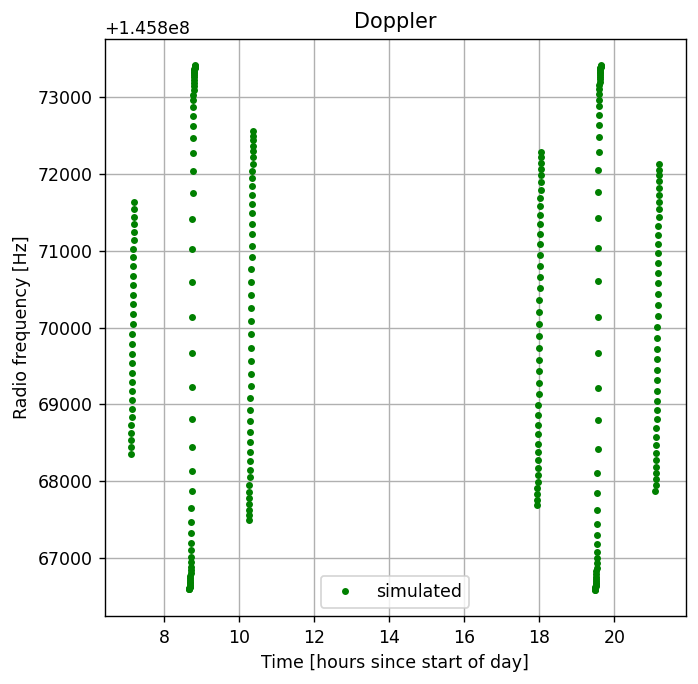

In [7]:
# Create the DopTrack station
define_doptrack_station(bodies)

# Define observation settings
observation_settings = define_ideal_doppler_settings()

# Create list of observation times, with one Doppler measurement every 10 seconds
possible_obs_times = []
obs_time_step = 10.0
current_time = start_recording_day
while current_time < final_epoch:
    possible_obs_times.append(current_time)
    current_time = current_time + obs_time_step

# Simulate (ideal) observations
# Checking the vivibility in the obseration window and calculataing ideal range rate.
simulated_observations = simulate_observations(possible_obs_times, observation_settings, propagator_settings, bodies, initial_epoch, 5)

simulated_obs_times = np.array(simulated_observations.concatenated_times)
simulated_doppler = simulated_observations.concatenated_observations

# Plot simulated Doppler data
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Doppler')
ax.plot((simulated_obs_times - start_recording_day)/3600, simulated_doppler, label='simulated', color='red', linestyle='none', marker='.')
ax.legend()
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('Doppler [m/s]')
plt.grid()
plt.show()

# with doppler formula, calculate simulated frequency
satellite_frequency = 145870000
speed_of_light = 299792458

frequency_received = (1-simulated_doppler/speed_of_light)*satellite_frequency

# Plot simulated freuqency data
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Doppler')
ax.plot((simulated_obs_times - start_recording_day)/3600, frequency_received, label='simulated', color='green', linestyle='none', marker='.')
ax.legend()
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('Radio frequency [Hz]')
plt.grid()
plt.show()

# --------------------------------------
# 3: Load real observations
# --------------------------------------

During your visit at the DopTrack facility, you have recorded your own frequency passes and the automated processor has converted the frequency measurements into range-rate data. 
The Doppler Tracking experiment (DopTrack) uses communication signals to generate observables of satellites. The following schematic shows the different hardware components that are used in the DopTrack setup.

![groundstation sketch](fig/sketch.png)
 
The figure depicts a schematic sketch of the hardware components of the DopTrack ground station. DopTrack has two omni-directional antennas in the UHF and VHF frequency bandwidths. After amplification of the received signals, they are fed to the in the AOR5001DX radio. An antenna selector is in between, such that it is possible to switch between antennas easily. 
The radio is responsible for pre-filtering the received signal, but also to tune to a certain frequency you want to listen to. The radio sends the signal to the USRP-N210 Software Defined Radio (SDR), which converts the analog signal to digital data. With the SDR you are able to control the sampling rate, which is linked to the size of the bandwidth you want to record. The SDR will send the data to the computer, where it can be stored/recorded. 

All the components that work with the antenna signal are synchronized in time and frequency: the radio, the SDR, and the computer. A GPS disciplined clock makes the synchronization possible. The purpose of this is to have accurate time stamping of the signal and also a stable frequency of the internal oscillators in the radio and SDR. The computer is linked to the Internet for remote access capabilities.

![Satellite range rate](fig/Satellite.png)

Due to the Doppler effect satellite communication signals have a distinct S-shape in the frequency domain. The Doppler effect tells us that an observer can perceive the frequency of a transmitted signal differently if there are changes in the distance between the observer and transmitter. The first order approximation of this frequency change can be expressed as follows:

>$f_{station}=\Big(1-\frac{\Delta v}{c}\Big) f_0$

The transmitted frequency, $f_0$, is changed by the relative velocity between the transmitting satellite and the receiver in the ground station, $\Delta v = v_s - v_r$. The speed of light is represented by $c$. In this way, you are able to calculate the received frequency, $f_{station}$. Of course, in satellite tracking, we are interested in the line-of-sight velocity, $\Delta v$, which is called range-rate. 

So, by measuring the observed frequency on the ground, we are able to obtain the range-rate observable for the transmitting satellite. This is what you will(/have) record(ed) at the DopTrack facility.

### Your data
Now it is your time to look at the data recorded and how well they are related to the simulated observations. Default code uses Delfi-C3 data sets that are linked to the .yml file used in the propagation part of this notebook.

**IN THIS BLOCK**: you can add your own data or other data sets related to the propogated orbit you used in the variable `data`. Place the `.32fc` file in the *data* directory and the `.yml` file in the *metadata* directory

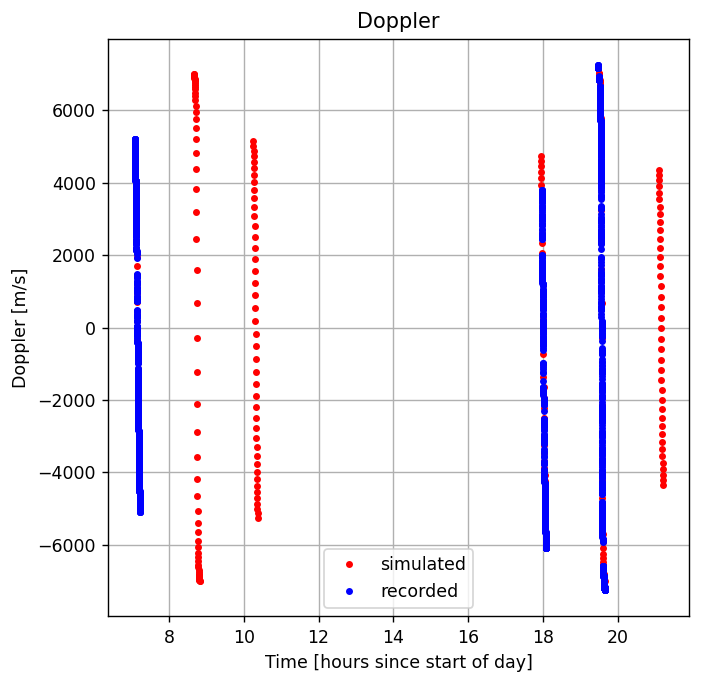

In [8]:
# Observation files to be uploaded
data = ['Delfi-C3_32789_202004020904.DOP1C', 'Delfi-C3_32789_202004021953.DOP1C', 'Delfi-C3_32789_202004022126.DOP1C']

# Process observations.
# This loads the recorded observations and retrieve the start of each tracking pass
passes_start_times, passes_end_times, observation_times, observations_set = load_and_format_observations(data_folder, data)

# Retrieve measured Doppler values
real_doppler = observations_set.concatenated_observations


# Plot simulated vs. real Doppler
fig = plt.figure(figsize=(6,6), dpi=125)
ax = fig.add_subplot()
ax.set_title(f'Doppler')
ax.plot((np.array(simulated_obs_times) - start_recording_day)/3600, simulated_doppler, label='simulated', color='red', linestyle='none', marker='.')
ax.plot((np.array(observation_times) - start_recording_day)/3600, convert_frequencies_to_range_rate(real_doppler), label='recorded', color='blue', linestyle='none', marker='.')
ax.legend()
ax.set_xlabel('Time [hours since start of day]')
ax.set_ylabel('Doppler [m/s]')
plt.grid()
plt.show()

# --------------------------------------
# 4: Compare simulated and recorded data for single pass
# --------------------------------------

From the previous figure it seems that the predicted model is able to capture the observed data quite accurate. To determine how accurate we select a single pass with `index_pass` parameter and inspect this data.

In the DopTrack terminology, the difference between the observed range-rate and the predicted range-rate is called the first residual.

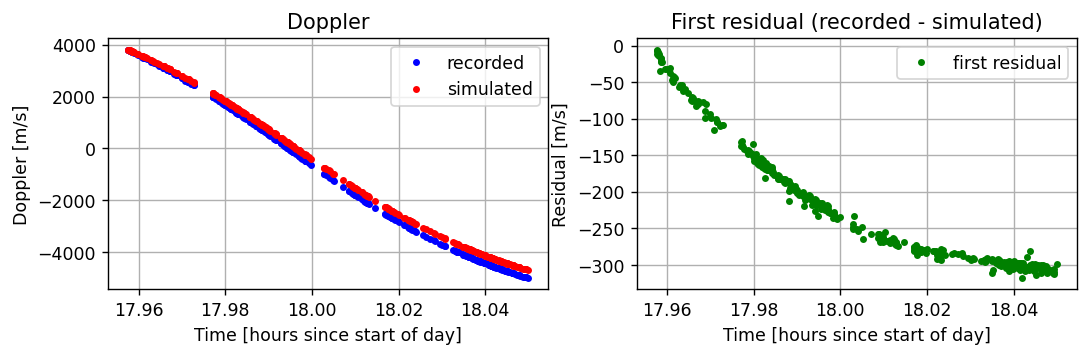

In [9]:
# Index of the *recorded* pass of interest (warning: the number of recorded passes might differ from the number of simulated passes)
index_pass = 1
single_pass_start_time = passes_start_times[index_pass]
single_pass_end_time = passes_end_times[index_pass]

# Retrieve recorded Doppler data for single pass
real_obs_single_pass = get_observations_single_pass(single_pass_start_time, single_pass_end_time, observations_set)

# Retrieve simulated Doppler data for single pass
simulated_obs_single_pass = get_observations_single_pass(single_pass_start_time, single_pass_end_time, simulated_observations)

# Interpolate simulated and recorded observations to identical times
interpolated_simulated_obs, interpolated_real_obs = interpolate_obs(simulated_obs_single_pass, real_obs_single_pass)
interpolated_times = interpolated_simulated_obs[:,0]

# Compute first residual between recorded and simulated observations
first_residual_obs = interpolated_real_obs[:,1] - interpolated_simulated_obs[:,1]


# Plot single pass observations (both recorded and simulated, as well as first and second residuals)

fig = plt.figure(figsize=(10,6), dpi=125)
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

ax1 = fig.add_subplot(2,2,1)
ax3 = fig.add_subplot(2,2,2)

ax1.plot((interpolated_times - start_recording_day)/3600, interpolated_real_obs[:,1], label='recorded', color='blue', linestyle='none', marker='.')
ax1.plot((interpolated_times - start_recording_day)/3600, interpolated_simulated_obs[:,1], label='simulated', color='red', linestyle='none', marker='.')
ax1.grid()
ax1.set_title(f'Doppler')
ax1.legend()
ax1.set_xlabel('Time [hours since start of day]')
ax1.set_ylabel('Doppler [m/s]')

ax3.plot((interpolated_times - start_recording_day)/3600, first_residual_obs, label='first residual', color='green', linestyle='none', marker='.')
ax3.grid()
ax3.set_title(f'First residual (recorded - simulated)')
ax3.legend()
ax3.set_xlabel('Time [hours since start of day]')
ax3.set_ylabel('Residual [m/s]')

plt.show()

Over time we have found that in the Delfi-C3 data there is in many passes a linear drift in the frequency data, with respect to the predicted range-rate. We hypothesised that there is a linear drift in the onboard oscillator or an other system that is responsible for a linear drift in the transmitted frequency. As a first data anaylysis, a linear drift is fitted through the first residual. The resulting residual is called the second residual, which should be free of any onboard clock drifts. 

*Some background*: To test this hypothesis we have observed over the years different satellites. One of them is the Nayif-1, which has a much better onboard clock and radio, less affected by drifts. We have found that the Nayif-1 data has better quality and is less pronounced by clock drift. This partly confirms our hypothesis, but much is still unclear and need to be studied.

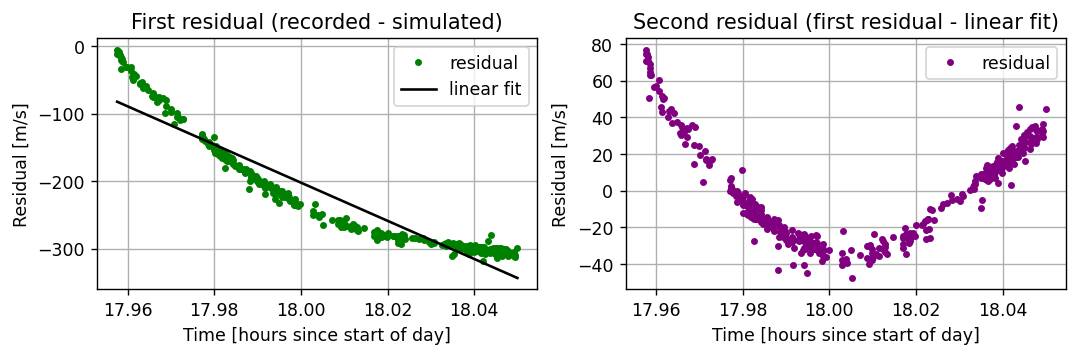

In [10]:
# Perform linear regression on first residual
linear_fit = LinearRegression().fit(interpolated_times.reshape((-1, 1)), first_residual_obs)

# Retrieve fit model
fit = linear_fit.predict(np.linspace(interpolated_times[0], interpolated_times[len(interpolated_times)-1]).reshape((-1, 1)))

# Compute second residual after removing linear fit
second_residual_obs = first_residual_obs - linear_fit.predict(interpolated_times.reshape((-1, 1)))

fig = plt.figure(figsize=(10,6), dpi=125)
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

ax3 = fig.add_subplot(2,2,1)
ax4 = fig.add_subplot(2,2,2)

ax3.plot((interpolated_times - start_recording_day)/3600, first_residual_obs, label='residual', color='green', linestyle='none', marker='.')
ax3.plot((np.linspace(interpolated_times[0], interpolated_times[len(interpolated_times)-1]) - start_recording_day)/3600, fit, label='linear fit', color='black', linestyle='-')
ax3.grid()
ax3.set_title(f'First residual (recorded - simulated)')
ax3.legend()
ax3.set_xlabel('Time [hours since start of day]')
ax3.set_ylabel('Residual [m/s]')

ax4.plot((interpolated_times - start_recording_day)/3600, second_residual_obs, label='residual', color='purple', linestyle='none', marker='.')
ax4.grid()
ax4.set_title(f'Second residual (first residual - linear fit)')
ax4.legend()
ax4.set_xlabel('Time [hours since start of day]')
ax4.set_ylabel('Residual [m/s]')

plt.show()

# Report:

For this assignment you are asked to report on your findings. Run the full note book with the default values to get experience with the code. Then you need to alter the code to do the following:

- Part 1 and 2: run these with a new TLE to make predictions of a satellite pass over Delft
- Submit your results (pdf of the notbook with outcomes) to ask for a DopTrack visit
- After the DopTrack visit use your own data to perform Part 3 and 4

Report on your findings by running the notebook with your own datafiles and write some discussion below. Hand in a pdf file of the newly run Jupyter notebook.

### Discussion:

Name student:

Student number:
    
Experimental observations (max 500 words):